In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# Load Zachary's Karate Club graph and build its adjacency matrix
G = nx.karate_club_graph()
n = G.number_of_nodes()
A = nx.to_numpy_array(G, nodelist=sorted(G.nodes()))
print("Adjacency matrix A:\n", A)




Adjacency Matrix A:
 [[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]


In [30]:
# Compute degree vector k and total number of edges m
k = np.sum(A, axis=1)
m = np.sum(k) / 2.0
# Build the modularity matrix B = A - (k k^T) / (2m)
B = A - np.outer(k, k) / (2*m)
print("Modularity matrix B:\n", B)

# Container for final communities (filled after recursive splitting)
final_communities = []

# Brief sanity check: use the leading eigenvector of B for an initial partition
eigenvalues, eigenvectors = np.linalg.eig(B)
leading = eigenvectors[:, np.argmax(eigenvalues)]
s = np.sign(leading)
s[s == 0] = 1  # treat zeros as positive to avoid empty groups
Q = (s.T @ B @ s) / (4 * m)
print("Initial modularity Q:", Q)

Modularity Matrix B:
 [[-3.81818182  1.36363636  2.         ...  0.09090909 -3.45454545
  -4.36363636]
 [ 1.36363636 -1.82034632  3.92857143 ... -1.31818182 -2.38528139
  -3.01298701]
 [ 2.          3.92857143 -2.35714286 ... -1.5        -0.71428571
  -3.42857143]
 ...
 [ 0.09090909 -1.31818182 -1.5        ... -0.95454545  2.27272727
   1.81818182]
 [-3.45454545 -2.38528139 -0.71428571 ...  2.27272727 -3.12554113
   1.05194805]
 [-4.36363636 -3.01298701 -3.42857143 ...  1.81818182  1.05194805
  -4.98701299]]
Modularity Score Q: (0.4036281179138322+0j)


In [ ]:
iter_data = []  # Store community assignments and metrics per iteration
pos = nx.spring_layout(G, seed=42)  # Fixed layout for all visualizations

def split_community(nodes, B_full, A_full):
    
    #Tring to split a community using spectral method Returns (can_split, group1, group2, eigenvalue)
    
    nc = len(nodes)
    if nc <= 1:
        return False, nodes, [], 0
    
    # Extracting submatrix for this community
    idx = list(nodes)
    B_sub = B_full[np.ix_(idx, idx)]
    
    # Ensure symmetry / numerical stability
    B_sub = (B_sub + B_sub.T) / 2.0

    # Use symmetric eigensolver (real outputs) and take leading eigenpair
    evals, evecs = np.linalg.eigh(B_sub)           # safer for symmetric matrices
    lambda1 = float(evals[-1])
    u1 = np.real(evecs[:, -1])
    
    # stopping criterion (positive eigenvalue AND positive modularity gain)
    if lambda1 <= 1e-10:
        return False, nodes, [], lambda1

    # partition by sign of eigenvector
    s = np.sign(u1)
    s[s == 0] = 1  # Handle zeros as positive

    # compute modularity gain for this split (use full graph m defined earlier)
    delta_Q = (s.T @ B_sub @ s) / (4.0 * m)
    if delta_Q <= 1e-10:
        return False, nodes, [], lambda1

    g1 = [nodes[i] for i in range(nc) if s[i] > 0]
    g2 = [nodes[i] for i in range(nc) if s[i] < 0]

    if len(g1) == 0 or len(g2) == 0:
        return False, nodes, [], lambda1

    return True, g1, g2, lambda1



=== Starting Recursive Bisection ===



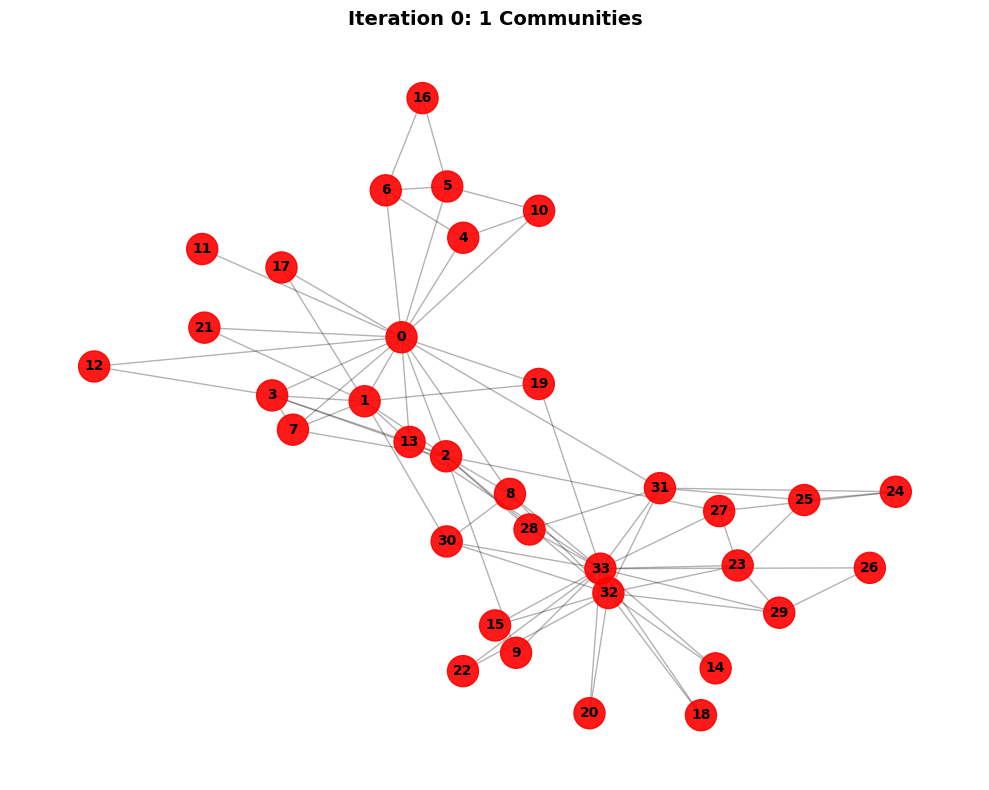

Iteration 0: 1 community


In [28]:

def compute_metrics(G, communities):
    """Compute all centrality metrics for current partition"""
    deg = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G)
    clo = nx.closeness_centrality(G)
    clu = nx.clustering(G)
    return deg, bet, clo, clu

def visualize_communities(G, pos, communities, iter_num):
    """Draw the graph with community colors"""
    colors = ['red', 'blue', 'green', 'orange', 
              'purple', 'yellow', 'cyan', 'magenta']
    
    node_colors = {}
    for c_idx, c in enumerate(communities):
        for node in c:
            node_colors[node] = colors[c_idx % len(colors)]
    
    color_list = [node_colors[i] for i in range(n)]
    
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color=color_list, 
                          node_size=500, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title(f'Iteration {iter_num}: {len(communities)} Communities', 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Recursive bisection algorithm
print("\n=== Starting Recursive Bisection ===\n")

communities = [list(range(n))]  # Start with all nodes
queue = [list(range(n))]  # Communities to process
iter_num = 0

# Store initial state
deg, bet, clo, clu = compute_metrics(G, communities)
iter_data.append({
    'iter': iter_num,
    'communities': [c.copy() for c in communities],
    'deg': deg.copy(),
    'bet': bet.copy(),
    'clo': clo.copy(),
    'clu': clu.copy()
})
visualize_communities(G, pos, communities, iter_num)
print(f"Iteration {iter_num}: {len(communities)} community")


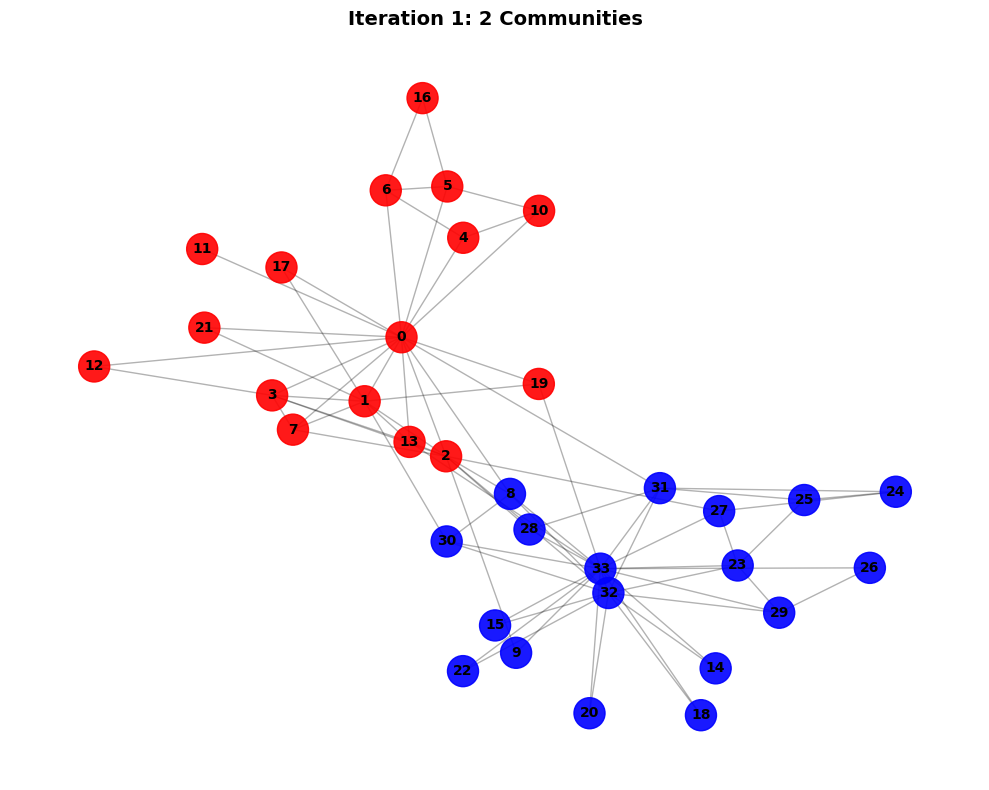

Iteration 1: Split into 2 communities (λ₁=17.1087)


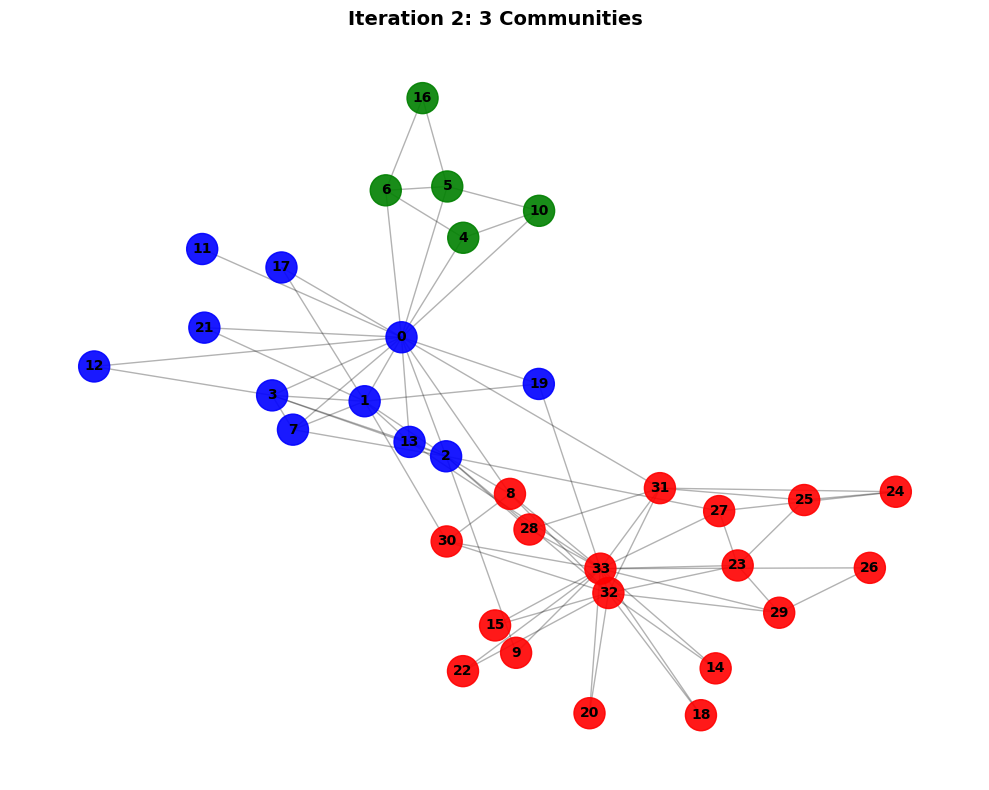

Iteration 2: Split into 3 communities (λ₁=10.6492)


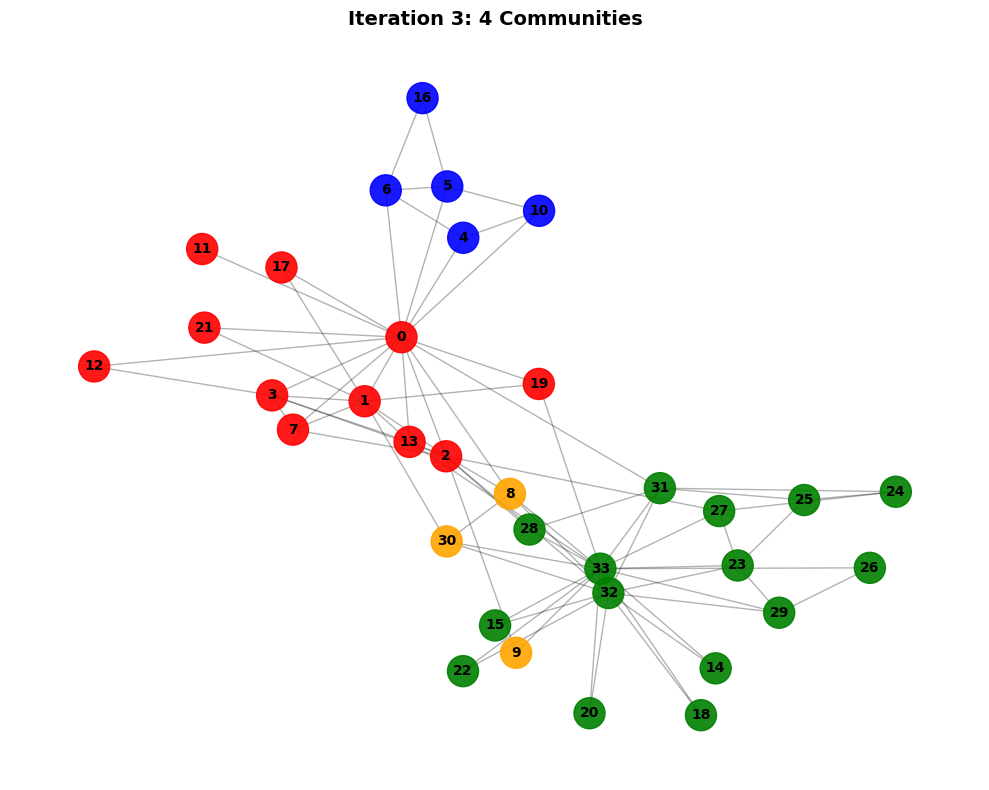

Iteration 3: Split into 4 communities (λ₁=8.0496)

⚠ Community is stable - no further splits possible

⚠ Community is stable - no further splits possible

⚠ Community is stable - no further splits possible


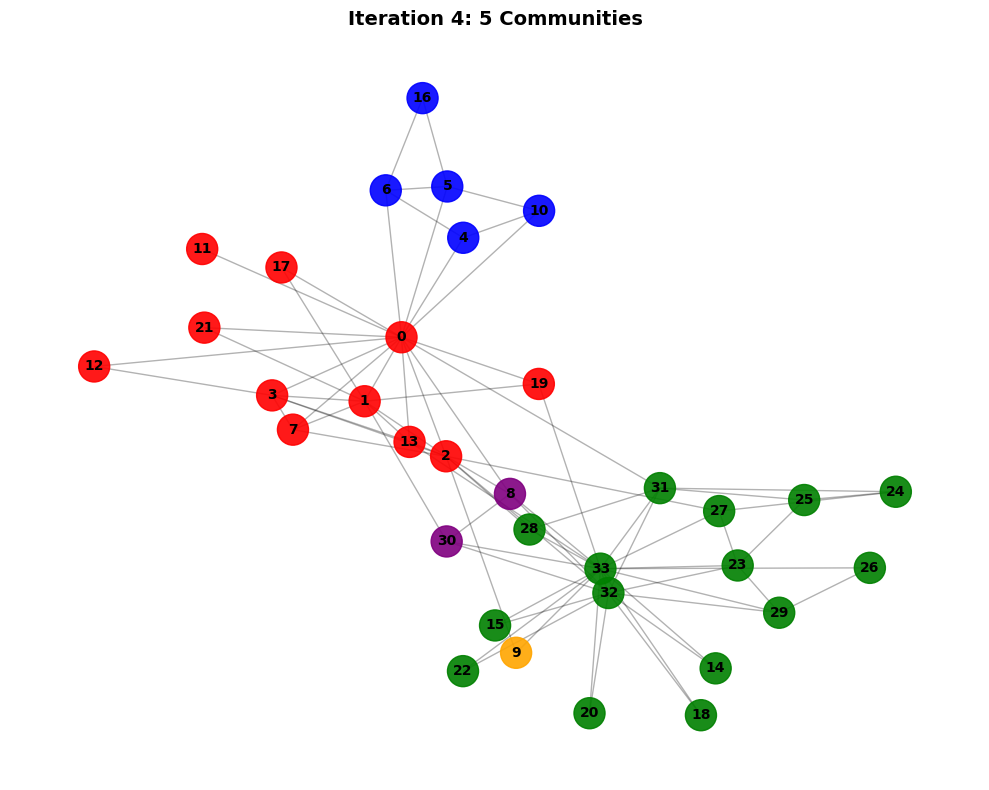

Iteration 4: Split into 5 communities (λ₁=2.1653)

⚠ Community is stable - no further splits possible

⚠ Community is stable - no further splits possible

=== Final Result: 5 communities ===
Community 1: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 2: [4, 5, 6, 10, 16]
Community 3: [14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33]
Community 4: [9]
Community 5: [8, 30]

Final Modularity Q: 0.4317


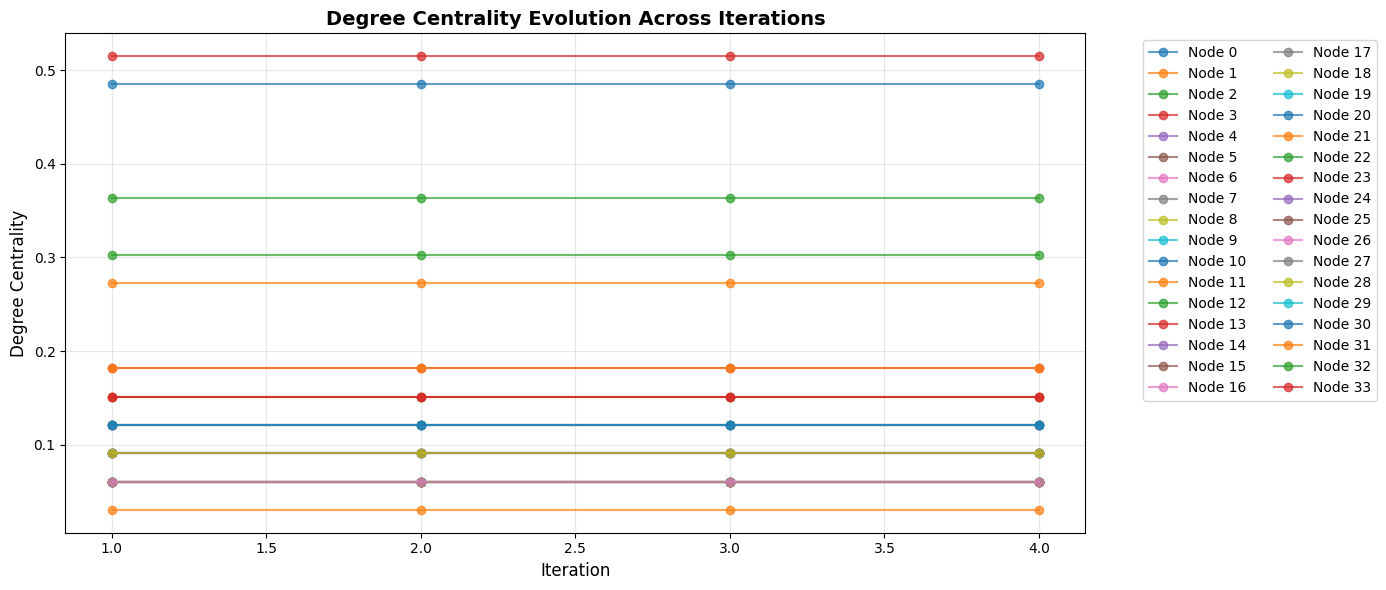

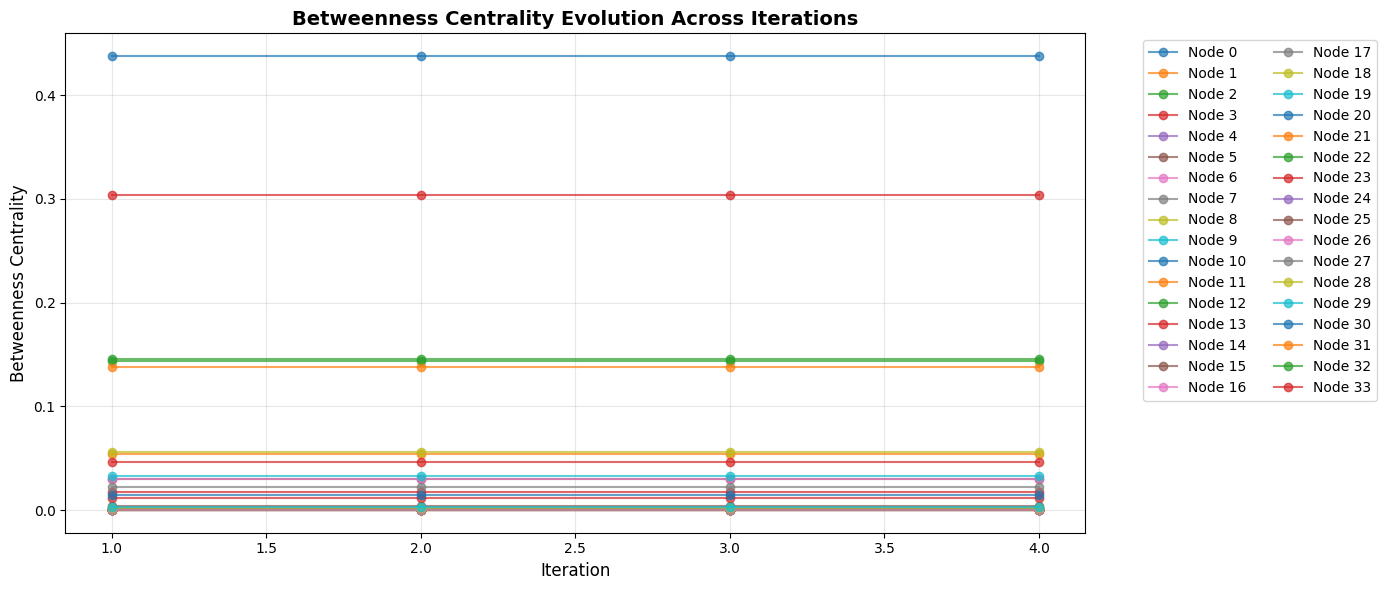

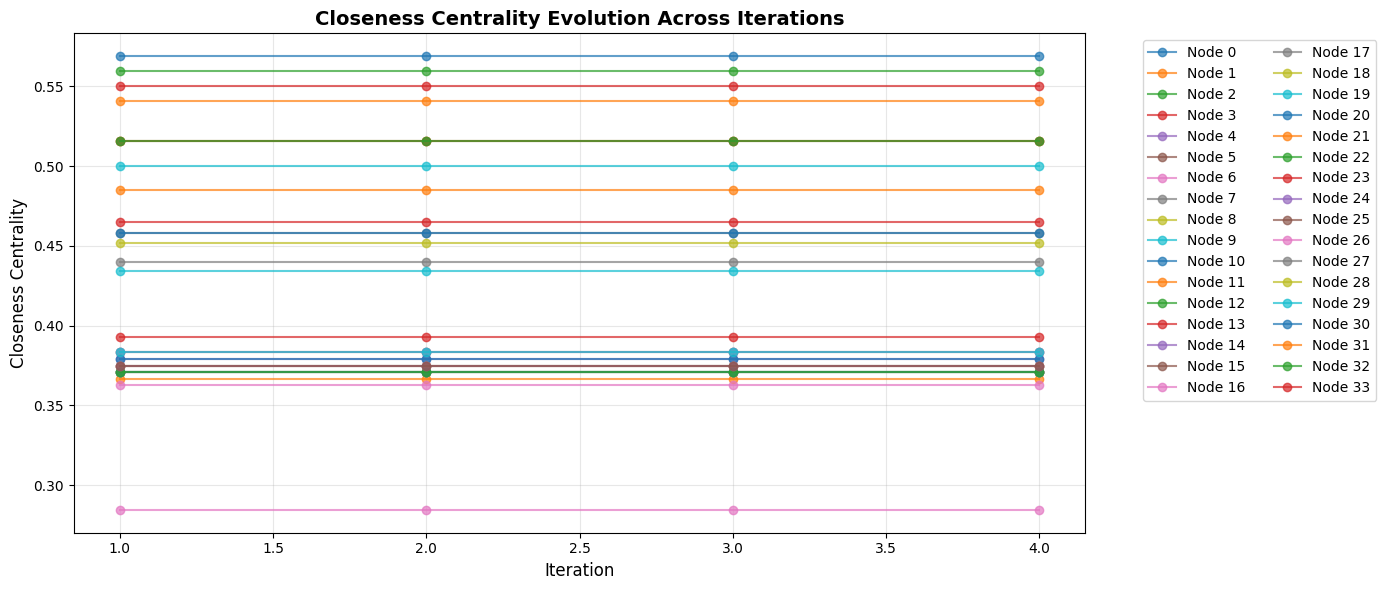

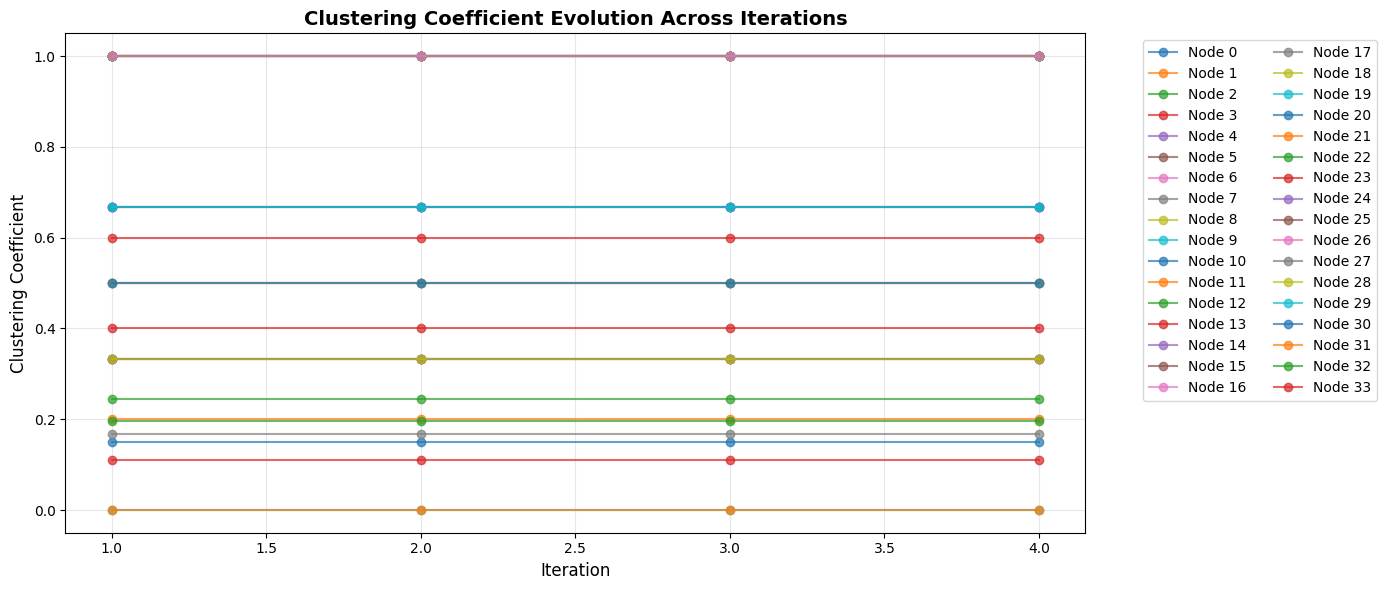


=== Key Nodes Analysis ===

Top 5 by Degree Centrality:
  Node 33: 0.5152
  Node 0: 0.4848
  Node 32: 0.3636
  Node 2: 0.3030
  Node 1: 0.2727

Top 5 by Betweenness Centrality:
  Node 0: 0.4376
  Node 33: 0.3041
  Node 32: 0.1452
  Node 2: 0.1437
  Node 31: 0.1383

=== Final Communities ===
Community 1: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 2: [4, 5, 6, 10, 16]
Community 3: [14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33]
Community 4: [9]
Community 5: [8, 30]

Node -> Community assignments:
  Node 0: Community 1
  Node 1: Community 1
  Node 2: Community 1
  Node 3: Community 1
  Node 4: Community 2
  Node 5: Community 2
  Node 6: Community 2
  Node 7: Community 1
  Node 8: Community 5
  Node 9: Community 4
  Node 10: Community 2
  Node 11: Community 1
  Node 12: Community 1
  Node 13: Community 1
  Node 14: Community 3
  Node 15: Community 3
  Node 16: Community 2
  Node 17: Community 1
  Node 18: Community 3
  Node 19: Community 1
  Node 20: Community 3
  Node

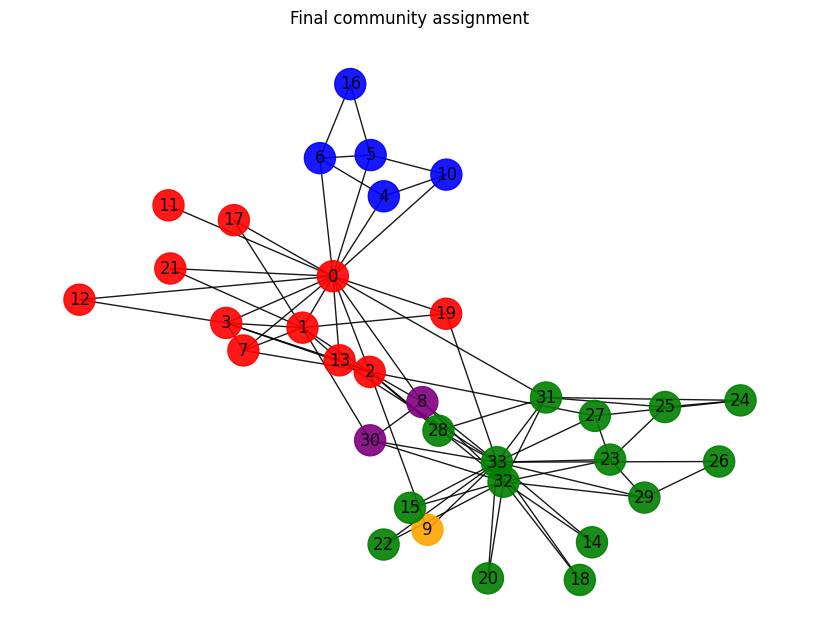

In [ ]:
# Process queue
while queue:
    curr = queue.pop(0)
    
    # Try to split
    can_split, g1, g2, lam, deltaQ = split_community(curr, B, A)
    
    if can_split:
        iter_num += 1
        
        # Remove old community and add new ones
        communities.remove(curr)
        communities.append(g1)
        communities.append(g2)
        
        # Add new communities to queue
        queue.append(g1)
        queue.append(g2)
        
        # Compute metrics
        deg, bet, clo, clu = compute_metrics(G, communities)
        iter_data.append({
            'iter': iter_num,
            'communities': [c.copy() for c in communities],
            'deg': deg.copy(),
            'bet': bet.copy(),
            'clo': clo.copy(),
            'clu': clu.copy()
        })
        
        # Visualize
        visualize_communities(G, pos, communities, iter_num)
        print(f"Iteration {iter_num}: Split into {len(communities)} communities (λ₁={lam:.4f}, ΔQ={deltaQ:.4e})")
    else:
        print(f"\n⚠ Community is stable - no further splits possible")

print(f"\n=== Final Result: {len(communities)} communities ===")
for i, c in enumerate(communities):
    print(f"Community {i+1}: {sorted(c)}")

# Calculate final modularity
final_Q = 0
for c in communities:
    for i in c:
        for j in c:
            final_Q += B[i, j]
final_Q /= (2 * m)
print(f"\nFinal Modularity Q: {final_Q:.4f}")

# Plot metric evolution
metrics = ['deg', 'bet', 'clo', 'clu']
metric_names = ['Degree Centrality', 'Betweenness Centrality', 
                'Closeness Centrality', 'Clustering Coefficient']

for metric, name in zip(metrics, metric_names):
    plt.figure(figsize=(14, 6))
    
    for node in range(n):
        values = [iter_data[i][metric][node] for i in range(len(iter_data))]
        iters = [iter_data[i]['iter'] for i in range(len(iter_data))]
        plt.plot(iters, values, marker='o', label=f'Node {node}', alpha=0.7)
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel(name, fontsize=12)
    plt.title(f'{name} Evolution Across Iterations', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Summary statistics for key nodes
print("\n=== Key Nodes Analysis ===")
final_deg = iter_data[-1]['deg']
final_bet = iter_data[-1]['bet']

top_deg = sorted(final_deg.items(), key=lambda x: x[1], reverse=True)[:5]
top_bet = sorted(final_bet.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 by Degree Centrality:")
for node, val in top_deg:
    print(f"  Node {node}: {val:.4f}")

print("\nTop 5 by Betweenness Centrality:")
for node, val in top_bet:
    print(f"  Node {node}: {val:.4f}")

# === Assigning nodes to communities and visualize final assignment ===
print("\n=== Final Communities ===")
for i, c in enumerate(communities):
    print(f"Community {i+1}: {sorted(c)}")

# Assigning each node to a community id (1-based) and set as node attribute
node_community = {}
for i, c in enumerate(communities):
    cid = i + 1
    for node in c:
        node_community[node] = cid
        G.nodes[node]['community'] = cid

print("\nNode -> Community assignments:")
for node in sorted(node_community.keys()):
    print(f"  Node {node}: Community {node_community[node]}")

# Visualize final assignment with consistent colors
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
color_map = [colors[(node_community[node]-1) % len(colors)] for node in range(n)]
plt.figure(figsize=(8,6))
nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, alpha=0.9)
plt.title('Final community assignment')
plt.axis('off')
plt.show()

<span style="font-family: 'Georgia', serif; font-size:15px;">**Discussion**</span>

<span style="font-family: 'Georgia', serif; font-size:13px;">For this assignment I implemented a recursive spectral bisection that automatically splits Zachary's Karate Club into communities. Although the historical story emphasizes two main factions (Mr. Hi and the President), the algorithm uncovered five distinct communities — two larger clusters plus smaller, tightly knit subgroups and a couple of outliers (e.g., Node 9).</span>

<span style="font-family: 'Georgia', serif; font-size:13px;">Notably, <span style="background-color:#ffcc80">Node 0 (Mr. Hi)</span> and <span style="background-color:#ffcc80">Node 33 (the President)</span> remained central within the two largest clusters throughout the splitting process. This supports that the spectral method identifies structurally important nodes (leaders), not just arbitrary partitions.</span>

<span style="font-family: 'Georgia', serif; font-size:13px;">Metric changes observed during recursion:</span>

- **Degree Centrality**: The local degree increased for leaders as communities got smaller — within a final small community they connected to most members (local popularity increased).

- **Clustering Coefficient**: Generally increased for most nodes, consistent with removing weak ties and leaving tighter cliques where neighbors are also connected.

- **Betweenness Centrality**: Tended to decrease for former bridge nodes since cutting inter-group links reduced their role as intermediaries.

<span style="font-family: 'Georgia', serif; font-size:13px;"><strong>Conclusion</strong>: The spectral modularity approach reliably finds both the obvious split and smaller hidden communities. Careful stopping criteria (positive leading eigenvalue and positive modularity gain) were important to avoid over-splitting. Overall, the results show the method's effectiveness at revealing social structure from the adjacency data alone.</span>